In [1]:

# Sys imports
import json
import os
import sys
from tqdm import tqdm

os.environ["KERAS_BACKEND"] = "jax"

# Training API
import keras as keras
from keras import layers
import keras_nlp

# Data manipulation and exploration
import numpy as np
from scipy.stats import shapiro, kurtosis

# Data visualization
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# NLP
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import jax.numpy as jnp

# MLOps API
import mlflow
mlflow.set_tracking_uri('http://localhost:5000')


2024-04-15 09:11:28.348343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 09:11:28.348379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 09:11:28.349402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 09:11:28.977225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# EDA

## Data loading
There are 72M titles and views in the data used.

In [2]:
# DATA LOADER 
def parse_jsonl_optimized(filepath, num_lines_to_import=None):
    titles = []
    view_counts = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for i, line in enumerate(tqdm(file, desc="Processing")):
            # Check if the specified number of lines has been reached (if specified)
            if (num_lines_to_import is not None and i >= num_lines_to_import):
                break
            # Parse the current line
            data = json.loads(line)
            # Extract and store the title and view count
            titles.append(data['title'])
            view_counts.append(data['view_count'])
    return titles, view_counts

# Example usage: Import only the first 1000 lines from the file
file_path = '/mnt/datassd/train_data.jsonl'
num_lines_to_import = 100000  # You can adjust this number as needed
titles, view_counts = parse_jsonl_optimized(file_path, num_lines_to_import)

Processing: 100000it [00:00, 511124.00it/s]


## Create $Log_{10}(Data)$ and create tokenizer

When views are analyzed on their own, the MSE loss function does not make a lot of sense, there is a lot of variation in the data.

What's why we take $log_{10}$ to get the order of magnitude of the views ($10^x$).

In [3]:

from transformers import BertTokenizer, BertModel
from concurrent.futures import ThreadPoolExecutor

# Load BERT tokanizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Encoding all 70M datapoints takes ~45mins

In [4]:
""" SINGLE THREADED  """
encoded_inputs = [tokenizer.encode(title, add_special_tokens=True) for title in tqdm(titles, total=len(titles), desc="Encoding")]

Encoding: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:11<00:00, 8733.91it/s]


In [ ]:
# save the encoded_inputs to disk
np.save('encoded_inputs1m.npy', encoded_inputs)
# save view counts to ensure that the order is preserved
np.save('view_counts1m.npy', view_counts)

In [ ]:
encoded_inputs = np.load('encoded_inputs1m.npy', allow_pickle=True)
view_counts = np.load('view_counts1m.npy', allow_pickle=True)

In [ ]:
#""" SOMEWHAT MULTITHREADED """
#def encode_title(title):
#    return tokenizer.encode(title, add_special_tokens=True)
#with ThreadPoolExecutor() as executor:
#    encoded_inputs = list(tqdm(executor.map(encode_title, titles), total=len(titles), desc="Encoding"))

In the context of title engagement, UPPER CASED titles correlate with engagement, it is important to use a CASED tokenizer.

In [ ]:
# Testing cased inputs in tokenization
titulos_raros = [r'IS THIS TOKEN Cased?']
print(tokenizer.tokenize(titulos_raros[0]))
tokenizer.encode(titulos_raros[0], add_special_tokens=True)


In [ ]:
bert = BertModel.from_pretrained('bert-base-cased')

In [16]:
log_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))

# Bin the view counts in ranges 0-1, 1-2, 2-3, 3-4, 4-5, 5-6, 6-7, 7-8, 8+
def bin_data(views, a, b, n_bins):
    # Generate bin edges from a to b with n_bins
    if b > a and n_bins > 1:
        bin_edges = np.linspace(a, b, n_bins - 1)
    else:
        raise ValueError("Ensure that b > a and n_bins > 1")
    
    # Bin the data into categories
    view_bins = np.digitize(views, bin_edges, right=True)

    # Categorize data into n_bins categories
    view_categorical = to_categorical(view_bins, num_classes=n_bins)

    return view_categorical, view_bins


def reverse_bin_data(categorical_views, a, b, n_bins):
    # Check for valid input
    if b <= a or n_bins <= 1:
        raise ValueError("Ensure that b > a and n_bins > 1")

    # Calculate the bin width
    bin_width = (b - a) / n_bins
    
    # Find the bin indices from the categorical data
    bin_indices = np.argmax(categorical_views, axis=1)
    
    # Calculate the representative value for each bin. Using the bin center as the representative value.
    representative_values = a + bin_width * (bin_indices + 0.5)

    return representative_values

# IMPORTANT, IT SETS THE SCALE
a = 0
b = 8
n_bins = 16


view_categorical, view_bins = bin_data(log_view_count, a, b, n_bins)

/tmp/ipykernel_40665/63614355.py:1: RuntimeWarning: divide by zero encountered in log10
  log_view_count = np.where(np.log10(view_counts) == -np.inf, 0, np.log10(view_counts))


In [19]:
log_view_count[10], reverse_bin_data(view_categorical, a, b, n_bins)[10],view_categorical[10]

(4.589245675052506,
 4.75,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))

## Data Normalization tests

First, let's see the distribution of view counts

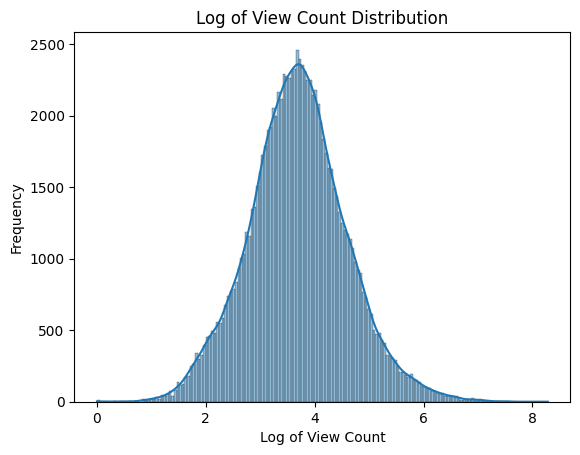

In [20]:
# See Y view count distribution


sns.histplot(log_view_count, kde=True)
plt.title("Log of View Count Distribution")
plt.xlabel("Log of View Count")
plt.ylabel("Frequency")
plt.show()

In [21]:
shapiro_test_stat, shapiro_p_value = shapiro(log_view_count)
kurtosis_value = kurtosis(log_view_count, fisher=True)

shapiro_test_stat, shapiro_p_value, kurtosis_value

/home/jay/.local/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9969961643218994, 4.630070837579155e-37, 0.3967178269496112)

In [22]:
sample_titles_i = 500
print(view_counts[sample_titles_i:sample_titles_i+5])
print(log_view_count[sample_titles_i:sample_titles_i+5])
titles[sample_titles_i:sample_titles_i+5]


[6682, 9904, 24762, 14664, 19519]
[3.82490647 3.99581063 4.39378572 4.16625245 4.29045756]


['Capricorn 1st -15th May 2019 ~The Devils Bate Capricorn ~ #Headsup',
 'Sagittarius 15th -31st April 2019 ~ With Great Power, Comes Greater Responsibility Sag ~',
 'Scorpio 15th-31st April 2019 ~ Its all coming out Scorpio, Use your intuition now ~',
 'Libra 15th-31st April 2019 ~ Ultimatum time Libra, Someone is dropping you or you them~',
 'Virgo 15th-31st April 2019 ~ Virgo this change will have far reaching consequences on your life ~']

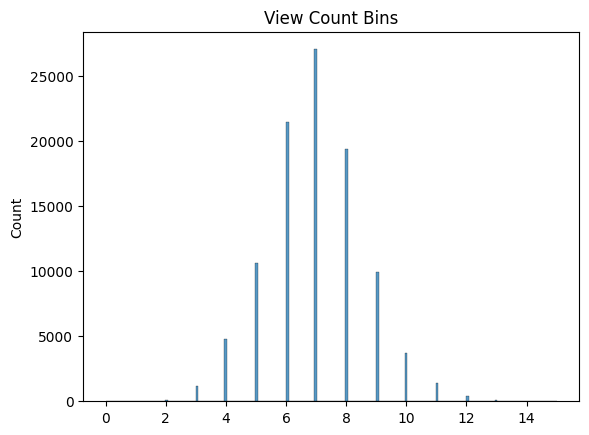

In [23]:

# Histogram the bins
sns.histplot(view_bins, kde=False)
plt.title("View Count Bins")
plt.show()

Now let's see the ditribution of lenghts of titles.

We need to have a cutoff at a certain token lenght. So let's visualize when it would be appropriate to cut titles off.

In [ ]:
sns.histplot([len(encoded_input) for encoded_input in encoded_inputs], bins=50)
plt.title("Histogram of tokenized title lengths")
plt.xlabel("Length of tokenized title")
plt.ylabel("Number of titles")
plt.show()

Probably at 40 tokens, the cutoff would preserve most of the information. (Remember YouTube titles have a 100 char limit)

In [25]:
max_length = 40  # Ensure your data is adjusted accordingly

padded_inputs = pad_sequences(encoded_inputs, maxlen=max_length, padding='post', truncating='post')


In [ ]:
# Just making sure, all inputs are the same length of 40 
sns.histplot([len(padded_input) for padded_input in padded_inputs], bins=50)
plt.title("Histogram of padded title lengths")
plt.xlabel("Length of padded title")
plt.ylabel("Number of titles")
plt.show()

Some samples to see the PADs

In [26]:
sample = [tokenizer.decode(padded_input) for padded_input in padded_inputs[90:100]]
sample

['[CLS] Libra 1st - 7th October 2019 ~ Your Week Ahead ~ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Gemini 1st - 7th October 2019 ~ Your Week Ahead ~ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Taurus 1st - 7th October 2019 ~ Your Week Ahead ~ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Pisces 1st - 7th October 2019 ~ Your Week Ahead ~ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] Capricorn 1st - 7th November ~ Your Week Ahead ~ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [27]:
X_t = jnp.array(padded_inputs)
Y_t = jnp.array(view_categorical)

vocab_size = 30522  # Adjusted to match BERT's vocabulary size for bert-base-cased
embedding_dim = 768  # Standard BERT-base embedding dimension
transformer_encoder_layers = 1  # Increase this for a larger model
num_heads = 12  # Increase this for a larger model
intermediate_dim = 768*2  # Dimensionality of the encoder layers and the pooler layer
dropout_rate = 0.1  # Dropout rate for regularization


In [28]:
# Input layer
inputs = keras.Input(shape=(max_length,), dtype='int32')

# Embedding layer
embedding_layer = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=vocab_size, 
    sequence_length=max_length, 
    embedding_dim=embedding_dim,
)

x = embedding_layer(inputs)

# Transformer blocks
for _ in range(transformer_encoder_layers):
    encoder = keras_nlp.layers.TransformerEncoder(
        num_heads=num_heads,
        intermediate_dim=intermediate_dim,
        activation='relu',
        dropout=dropout_rate,
    )
    x = encoder(x)

# Pooling and output layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(embedding_dim, activation='relu')(x)
outputs = layers.Dense(n_bins, activation='softmax')(x)  # 8 classes for the bins

# Model compilation
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 40, 768)        │    23,471,616 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 40, 768)        │     4,727,040 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │        12,304 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,801,552 (109.87 MB)

 Trainable params: 28,801,552 (109.87 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
class MlflowCallbackLogPerBatch(mlflow.keras_core.MLflowCallback):
    def on_batch_end(self, batch, logs=None):
        if self.log_every_n_steps is None or logs is None:
            return
        if (batch + 1) % self.log_every_n_steps == 0:
            self.metrics_logger.record_metrics(logs, self._log_step)
            self._log_step += self.log_every_n_steps


with mlflow.start_run() as run:
    model.fit(X_t, Y_t, batch_size=64, epochs=5, validation_split=0.2, callbacks= [MlflowCallbackLogPerBatch(run, log_every_epoch=False, log_every_n_steps=5)])
mlflow.end_run()

Using JAX backend.


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.3176 - loss: 1.8140 - val_accuracy: 0.2122 - val_loss: 2.2761
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4485 - loss: 1.3827 - val_accuracy: 0.1818 - val_loss: 2.4485
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5075 - loss: 1.2433 - val_accuracy: 0.1937 - val_loss: 2.6403
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5541 - loss: 1.1344 - val_accuracy: 0.1892 - val_loss: 2.7655
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5842 - loss: 1.0447 - val_accuracy: 0.1847 - val_loss: 2.7962


# Evaluation

In [33]:
# Load the eval input
eval_file_path = '/mnt/datassd/train_data.jsonl'
titles_eval, view_counts_eval = parse_jsonl_optimized(eval_file_path, num_lines_to_import*0.1)
encoded_evals = [tokenizer.encode(title_ev, add_special_tokens=True) for title_ev in tqdm(titles_eval, total=len(titles_eval), desc="Encoding")]
padded_evals = pad_sequences(encoded_evals, maxlen=max_length, padding='post', truncating='post')

# eval output
log_view_count_eval = np.where(np.log10(view_counts_eval) == -np.inf, 0, np.log10(view_counts_eval))
view_evals_test, view_evals_bins = bin_data(log_view_count_eval, a, b, n_bins)

Processing: 10000it [00:00, 326806.81it/s]
Encoding:   6%|██████████▍                                                                                                                                                     | 649/10000 [00:00<00:01, 6481.40it/s]

Encoding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8574.50it/s]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [34]:
Y_e = jnp.array(view_evals_test)
X_e = jnp.array(padded_evals)

In [46]:
Y_pred = model.predict(X_e)
actual = log_view_count_eval
predicted = reverse_bin_data(Y_pred, a, b, n_bins)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([4.75, 5.25, 4.25, ..., 4.25, 3.75, 3.75])

In [ ]:

# actual = []
# predicted = []

# for i in range(len(Y_pred)):
#     pr = reverse_bin_data(Y_pred[i], a, b, n_bins)
#     ac = reverse_bin_data(Y_e[i], a, b, n_bins)
#     print(f"Predicted: {pr}, Real: {ac}")
#     actual.append(ac)
#     predicted.append(pr)

len(predicted)

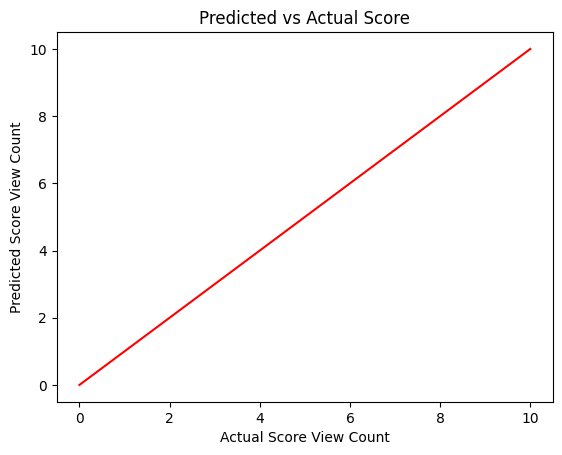

In [47]:
# Make scatter of predicted vs actual
plt.scatter(actual, predicted)
# Make a line
plt.plot([0, 10], [0, 10], color='red')
plt.title("Predicted vs Actual Score")
plt.xlabel("Actual Score View Count")
plt.ylabel("Predicted Score View Count")
plt.show()

In [ ]:
sns.histplot(predicted, kde=False)
plt.title("Predicted Score View Count")

In [ ]:
Y_pred

In [ ]:
# Arange titles by highest predicted view count
sorted_titles = [title for _, title in sorted(zip(Y_pred, titles_eval), reverse=True)]
sorted_titles[:50], sorted_titles[-50:]